# attempt to detect ticked/unticked and circled/not-circled images using openCV

In [ ]:
import importlib
import main
import os
importlib.reload(main)
from main import *
folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]


def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.
    
    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.
        
    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]
        
        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [
                f for f in files
                if os.path.splitext(f)[1].lower() == f'.{ext}'
            ]
        
        return files
    
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []
    



threshold = 60  # Set your desired threshold

folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]
for folder in folder_list:
    image_paths = list_files_in_folder(folder,ext="PNG")

    print(folder)
    for file_name in image_paths:
        full_file_path = os.path.join(folder, file_name)

        filename = full_file_path.split("/")[-1]
        name = filename.split(".")[0]
        unique_strings = [
        "no1_93",
        "no1_86",
        "yes1_2",
        "no1_96",
        "no1_97",
        "yes1_79",
        "no1_27",
        "no1_2",
        "no4",
        "no1_71",
        "yes1_60",
        "no1_22"
    ]

        # if name  in unique_strings:
        if name  in unique_strings or 1:
        # break   

            result_payload = process_image(full_file_path, threshold=threshold, show_plots=False)
            LOGGER.info(result_payload)



            # Save the resulting images with green or red text
            output_directory = 'results'
            file_name_prefix = os.path.splitext(os.path.basename(filename))[0]  # Use the original file name as prefix
            image = cv2.imread(full_file_path)
            annotated_image_path = annotate_image_openCV(
                image=image,
                result_payload=result_payload,
                output_path=output_directory,
                file_name_prefix=file_name_prefix,
        )

        

In [3]:
# epsilon_values = [0.01, 0.02, 0.03, 0.05]

# for epsilon_multiplier in epsilon_values:
#     print(f"\nTesting with epsilon_multiplier = {epsilon_multiplier}")
#     tick_detected, detection_info = detect_checkbox_with_tick(
#         gray,
#         area_threshold=100,
#         epsilon_multiplier=epsilon_multiplier,
#         debug=True,
#         show_plots=True
#     )

In [4]:
# param_ranges = {
#     'clahe_clip_limits': [1.0, 1.5, 2.0],
#     'tile_grid_sizes': [(4, 4), (8, 8)],
#     'block_sizes': [15, 21, 31],  # Must be odd numbers
#     'C_values': [2, 3, 5],
#     'area_thresholds': [50, 100, 200]
# }
# full_file_path = "dataset/images_test/no1_93.PNG"
# explore_detection_parameters(full_file_path, param_ranges)

# attempt to use a CNN model and identity detect ticked/unticked and circled/not-circled images

## training the model

INFO:__main__:Loading images from dataset
INFO:__main__:Folder path is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/
INFO:__main__:Processing label: .DS_Store
INFO:__main__:Processing label: ticked
INFO:__main__:Processing label: circled_yes
INFO:__main__:Processing label: images_test
INFO:__main__:Processing label: circled_no
INFO:__main__:Processing label: unticked
INFO:__main__:Labeling images
INFO:__main__:Splitting data into training, validation, and testing
INFO:__main__:Creating CNN model with dropout
/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
INFO:__main__:Compiling the model
INFO:__main__:Training the model


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 501ms/step - accuracy: 0.2664 - loss: 1.5307 - val_accuracy: 0.4154 - val_loss: 1.3830 - learning_rate: 0.0010
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 730ms/step - accuracy: 0.3053 - loss: 1.3805 - val_accuracy: 0.4769 - val_loss: 1.3654 - learning_rate: 0.0010
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3667 - loss: 1.3636 - val_accuracy: 0.5692 - val_loss: 1.1463 - learning_rate: 0.0010
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5797 - loss: 1.1063 - val_accuracy: 0.6615 - val_loss: 0.8580 - learning_rate: 0.0010
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 700ms/step - accuracy: 0.6291 - loss: 0.9026 - val_accuracy: 0.6769 - val_loss: 0.6747 - learning_rate: 0.0010
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - accuracy: 0.7282 - loss: 0.7122 - val_accuracy: 0.7692 - val_loss: 0.5316 - learning_rate: 0.0010
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 776ms/step - accuracy: 0.7718 - loss: 0

INFO:__main__:Evaluating the model


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
              precision    recall  f1-score   support

      ticked       0.96      0.94      0.95        48
    unticked       0.96      0.96      0.96        72
 circled_yes       0.95      0.86      0.90        22
  circled_no       0.88      1.00      0.93        21

    accuracy                           0.94       163
   macro avg       0.94      0.94      0.94       163
weighted avg       0.95      0.94      0.94       163



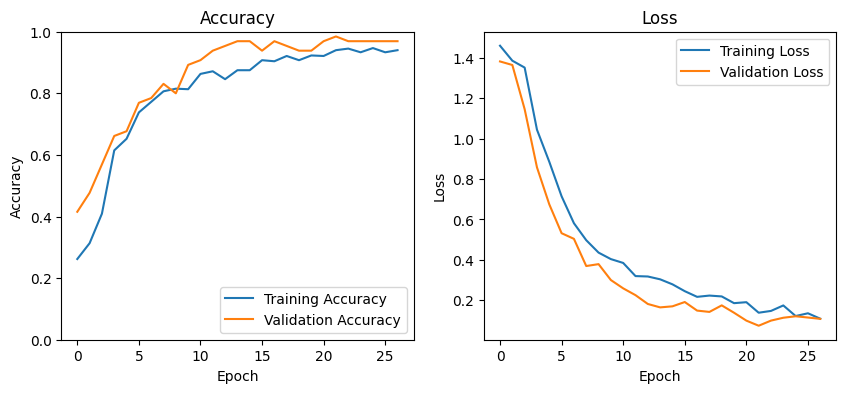

6/6 - 1s - 153ms/step - accuracy: 0.9448 - loss: 0.3042


INFO:__main__:Test accuracy: 0.9447852969169617


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import logging
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Initialize logger
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Load and preprocess images
def load_images_from_folder(folder):
    current_dir = os.getcwd()
    folder_path = os.path.join(current_dir, folder)
    LOGGER.info(f"Folder path is {folder_path}")
    images = []
    labels = []
    
    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder {folder_path} does not exist.")
    
    for label in os.listdir(folder_path):
        LOGGER.info(f"Processing label: {label}")
        if label == "images_test":
            continue
        label_folder = os.path.join(folder_path, label)
        if not os.path.isdir(label_folder):
            continue
        
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            if img is not None:
                img = cv2.resize(img, (80, 140))  # Resize to 80x140 (width x height) for the model
                images.append(img)
                labels.append(label)
    
    return np.array(images), np.array(labels)

# Load data
LOGGER.info("Loading images from dataset")
image_data, labels = load_images_from_folder('dataset/')
image_data = image_data.reshape(-1, 140, 80, 1)  # Add channel dimension for grayscale
image_data = image_data / 255.0  # Normalize the pixel values

# Convert labels to integers (e.g., ticked=0, unticked=1, circled_yes=2, circled_no=3)
LOGGER.info("Labeling images")
label_mapping = {'ticked': 0, 'unticked': 1, 'circled_yes': 2, 'circled_no': 3}
labels = np.array([label_mapping[label] for label in labels])

# Split data into training, validation, and testing
LOGGER.info("Splitting data into training, validation, and testing")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)  # 10% of training data for validation

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights_array))

# Create the CNN model
LOGGER.info("Creating CNN model with dropout")
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(140, 80, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Third convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Optional pooling layer if needed
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout layer added
model.add(layers.Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Compile the model
LOGGER.info("Compiling the model")
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
LOGGER.info("Training the model")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights)




# Use classification_report to compute F1-Score, Precision, and Recall
LOGGER.info("Evaluating the model")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
LOGGER.info(f'Test accuracy: {test_acc}')


Understanding the Classification Report

The classification report generated by sklearn.metrics.classification_report provides a detailed summary of the predictive performance of a classification model. It includes key metrics for each class in your dataset, helping you understand how well your model is performing, especially in cases of imbalanced datasets.
Metrics Included in the Classification Report

The report includes the following metrics for each class:

    Precision
    Recall
    F1-Score
    Support

These metrics provide insights into different aspects of your model's performance.
1. Precision

Definition:

    Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

Formula:
Precision=True Positives (TP)True Positives (TP)+False Positives (FP)
Precision=True Positives (TP)+False Positives (FP)True Positives (TP)​

Interpretation:

    Precision answers the question: "Of all instances that the model predicted as positive (e.g., a specific class), how many are actually positive?"
    A high precision indicates a low rate of false positives.

2. Recall (Sensitivity or True Positive Rate)

Definition:

    Recall is the ratio of correctly predicted positive observations to all actual positive observations.

Formula:
Recall=True Positives (TP)True Positives (TP)+False Negatives (FN)
Recall=True Positives (TP)+False Negatives (FN)True Positives (TP)​

Interpretation:

    Recall answers the question: "Of all actual positive instances, how many did the model correctly identify?"
    A high recall indicates a low rate of false negatives.

3. F1-Score

Definition:

    The F1-score is the harmonic mean of precision and recall. It combines both metrics into a single value.

Formula:
F1-Score=2×Precision×RecallPrecision+Recall
F1-Score=2×Precision+RecallPrecision×Recall​

Interpretation:

    F1-score balances the trade-off between precision and recall.
    It's useful when you need to seek a balance between precision and recall, especially with uneven class distribution.

4. Support

Definition:

    Support refers to the number of actual occurrences of each class in the dataset.

Interpretation:

    It shows how many samples of each class are present in the test dataset.
    Important for understanding the weight of each class in the overall performance metrics.

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


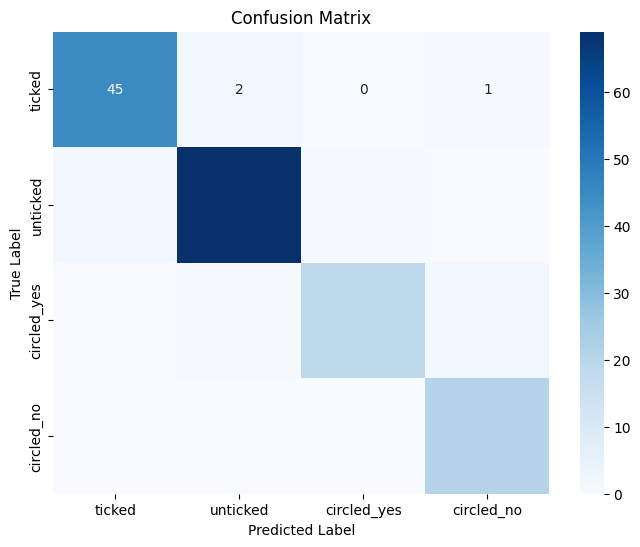

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Now compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create ordered list of class names based on label_mapping
label_mapping = {'ticked': 0, 'unticked': 1, 'circled_yes': 2, 'circled_no': 3}
# Create a list of class names ordered by their label indices
class_names = [''] * len(label_mapping)
for class_name, index in label_mapping.items():
    class_names[index] = class_name

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## saving the model

In [3]:
# model.save('ticked_box_model.h5')
# model.save('ticked_box_model_new.keras')
model.save('ticked_box_model_more_images.keras')

## load the model

In [4]:


# Load the trained model globally so it's available in subsequent requests
# model = tf.keras.models.load_model('ticked_box_model_new.keras')
model = tf.keras.models.load_model('ticked_box_model_more_images.keras')



## predict

In [9]:
import importlib
import main
import os
importlib.reload(main)
from main import *

In [13]:
def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.
    
    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.
        
    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]
        
        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [
                f for f in files
                if os.path.splitext(f)[1].lower() == f'.{ext}'
            ]
        
        return files
    
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []

from io import BytesIO
folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]
widths = []
heights = []
aspect_ratios = []
        
threshold = 0.6  
for folder in folder_list:
    image_paths = list_files_in_folder(folder,ext="PNG")

    LOGGER.info(folder)
    for file_name in image_paths:
        LOGGER.info("\n\n")
        full_file_path = os.path.join(folder, file_name)
        LOGGER.info(f"processing image {full_file_path}")
        filename = full_file_path.split("/")[-1]
        image_name = filename.split(".")[0]
        unique_strings = [
        "no1_93",
        "no1_86",
        "yes1_2",
        "no1_96",
        "no1_97",
        "yes1_79",
        "no1_27",
        "no1_2",
        "no4",
        "no1_71",
        "yes1_60",
        "no1_22"
    ]
        

        image = cv2.imread(full_file_path)
        h, w = image.shape[:2]
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h)

        if file_name  in unique_strings:

        # if name  in unique_strings or 1:
        # break   
            try:
                with open(full_file_path, "rb") as image_file:
                     image_bytes = BytesIO(image_file.read())
                    
                result_payload = process_image_with_model(image_bytes, threshold,model)
                # Build consent dictionary
                consent = build_consent(result_payload, threshold)
                
                # Read the image using OpenCV for annotation
                image = cv2.imread(full_file_path)

                if image is None:
                    LOGGER.error("Failed to read the image for annotation.")
                    
                
                # Prepare annotation parameters
                output_directory = 'results_model'
                file_name_prefix = os.path.splitext(os.path.basename(full_file_path))[0]  # Use the original file name as prefix
                
                # Annotate the image
                annotated_image_path = annotate_image(
                    image=image,
                    consent=consent,
                    output_path=output_directory,
                    file_name_prefix=file_name_prefix
                )
                

            
            except Exception as e:
                LOGGER.exception("An unexpected error occurred in the main workflow.")
                


INFO:main:dataset/images_test
INFO:main:


INFO:main:processing image dataset/images_test/no1_89.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_79.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_75.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_70.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_64.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_43.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_80.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_2.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_65.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_71.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_69.PNG
INFO:main:


INFO:main:processing image dataset/images_test/no1_66.PNG
INFO:main:


INFO:main:processing image dataset/images_test/yes1_26.PNG
INFO:main:


INFO:main:processing image dat

In [128]:
len(widths)

5

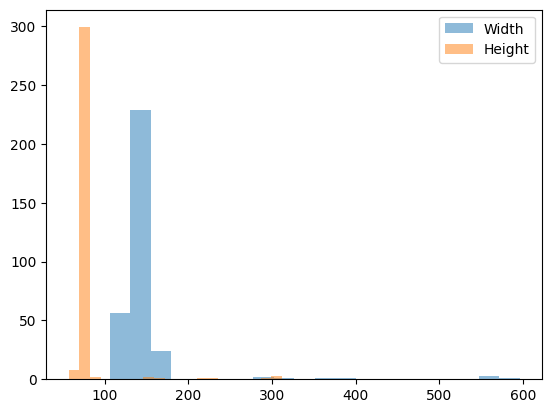

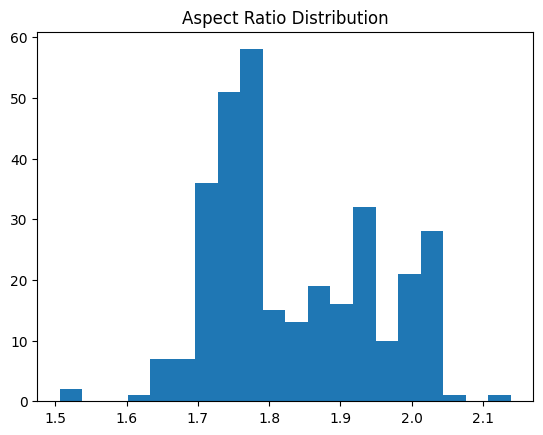

In [118]:
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.show()

plt.hist(aspect_ratios, bins=20)
plt.title('Aspect Ratio Distribution')
plt.show()